In [59]:
# model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
model_ckpt = "google/ViViT"
batch_size = 3 # batch size for training and evaluation

In [60]:
# !pip install pytorchvideo transformers evaluate -q

In [61]:
# from huggingface_hub import notebook_login

# notebook_login()

In [62]:
# !git config --global credential.helper store

## Loading the dataset

In [63]:
dataset_root_path = "../datasets/DAiSEE/t_50_dataset"

!find {dataset_root_path} | head -5

../datasets/DAiSEE/t_50_dataset
../datasets/DAiSEE/t_50_dataset/validation
../datasets/DAiSEE/t_50_dataset/validation/Very_Little_Engaged
../datasets/DAiSEE/t_50_dataset/validation/Very_Little_Engaged/4100192026.avi
../datasets/DAiSEE/t_50_dataset/validation/Very_Little_Engaged/4100262006.avi
find: ‘standard output’: Broken pipe
find: write error


In [64]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [65]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("validation/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 485


In [66]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("validation/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('../datasets/DAiSEE/t_50_dataset/train/Very_Little_Engaged/1813740138.avi'),
 PosixPath('../datasets/DAiSEE/t_50_dataset/train/Very_Little_Engaged/3100821069.avi'),
 PosixPath('../datasets/DAiSEE/t_50_dataset/train/Very_Little_Engaged/4110211040.avi'),
 PosixPath('../datasets/DAiSEE/t_50_dataset/train/Very_Little_Engaged/2100582056.avi'),
 PosixPath('../datasets/DAiSEE/t_50_dataset/train/Very_Little_Engaged/3503610168.avi')]

In [67]:
class_labels = sorted({str(path).split("/")[5] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['Highly_Engaged', 'Little_Engaged', 'Very_Highly_Engaged', 'Very_Little_Engaged'].


## Loading base Model

In [68]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import VivitImageProcessor, VivitForVideoClassification
from transformers import VivitModel


# image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
# model = VideoMAEForVideoClassification.from_pretrained(
#     model_ckpt,
#     label2id=label2id,
#     id2label=id2label,
#     ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
# )
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400", label2id=label2id, id2label=id2label,ignore_mismatched_sizes=True)

/home/saimai/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Constructing the datasets for training

In [69]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

We'll use the image_processor associated with the pre-trained model to obtain the following information:

Image mean and standard deviation with which the video frame pixels will be normalized.
Spatial resolution to which the video frames will be resized.

In [70]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "validation"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [71]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(184, 173, 154)

In [72]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [73]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 32, 224, 224])
video_name 3100622020.avi
video_index 30
clip_index 0
aug_index 0
label 0
Video label: Highly_Engaged


In [74]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

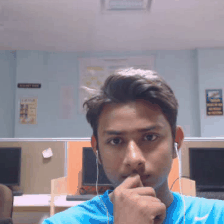

In [75]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

## Training the Model

In [76]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"../trained_models/{model_name}-finetuned-all-samples-engagement-levels"
num_epochs = 5

args = TrainingArguments(
    new_model_name,
    # output_dir="../trained_models/MAEmodel1",
    remove_unused_columns=False,
    # evaluation_strategy="epoch",   ## Module version issue
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    save_steps=1000, # save the model every N steps
    eval_steps=1000, # evaluate the model every N steps
    report_to='tensorboard',
    no_cuda=False, # use the GPU or not
)

In [77]:
import evaluate

metric = evaluate.load("accuracy")

In [78]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [79]:
import torch
torch.cuda.empty_cache()

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [80]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipykernel_99636/3087471478.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [77]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [78]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.798500,1.157115,0.421274
1,0.782900,1.097715,0.469909
2,1.026100,1.097845,0.570679
3,1.132400,0.989538,0.580126
4,0.767800,1.019817,0.578027


I cbpy damaged at 16 8
Error at MB: 344
/home/saimai/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
I cbpy damaged at 16 8
Error at MB: 344
/home/saimai/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), Rand

In [23]:
trainer.evaluate(train_dataset)

KeyboardInterrupt: 

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

In [ ]:
# trainer.push_to_hub()

## Inference

In [82]:
# trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)
# trained_model = VivitForVideoClassification.from_pretrained(new_model_name)
trained_model = VivitForVideoClassification.from_pretrained("../trained_models/ViViT-finetuned-50-samples-engagement-levels")
# trained_model = VideoMAEForVideoClassification.from_pretrained("../trained_models/videomae-base-finetuned-engagement-level-google-50S")

In [83]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 32, 224, 224])
video_name 5100452016.avi
video_index 74
clip_index 0
aug_index 0
label 1
Video label: Little_Engaged


/home/saimai/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [84]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [85]:
logits = run_inference(trained_model, sample_test_video["video"])

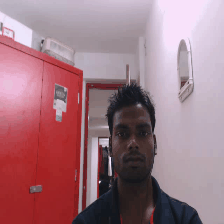

In [86]:
display_gif(sample_test_video["video"])

In [87]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", trained_model.config.id2label[predicted_class_idx])

Predicted class: LABEL_0


In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_test = [id2label[sample_test_video["label"]]]
# predictions = [trained_model.config.id2label[predicted_class_idx]]
# for stv in test_dataset:
#     logits = run_inference(trained_model, stv["video"])
#     y_test.append(id2label[stv["label"]])
#     predictions.append(trained_model.config.id2label[logits.argmax(-1).item()])

y_test = [sample_test_video["label"]]
predictions = [predicted_class_idx]
for stv in test_dataset:
    logits = run_inference(trained_model, stv["video"])
    y_test.append(stv["label"])
    predictions.append(logits.argmax(-1).item())

# cm = confusion_matrix(y_test, predictions)
# ConfusionMatrixDisplay(cm).plot()

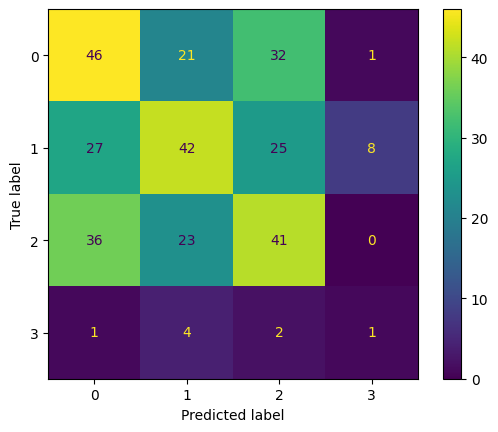

In [89]:
y_test = [id2label[y] for y in y_test]
predictions = [id2label[y] for y in predictions]
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [58]:
for i in range(4):
    print(trained_model.config.id2label[i])

Highly_Engaged
Little_Engaged
Very_Highly_Engaged
Very_Little_Engaged
